# Libraies

In [ ]:
# Import Necessary Libaries
%matplotlib inline
import os
import sys
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
from midi_utils import midiread, midiwrite
from matplotlib import pyplot as plt
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Pre-Defined Parameters

In [ ]:
# Customize Training Parameters Here
CLIP = 3
EPOCHS_NUMBER = 25
HIDDEN_SIZE = 512
RNN_TYPE = "gru"
DROPOUT = "normal"
DROPOUT_RATE = .5
OPTIMIZER_TYPE = "adam"
criterion = nn.CrossEntropyLoss().cuda()
criterion_val = nn.CrossEntropyLoss().cuda()

# Customize Outout MIDI File Here 
SAMPLE_LENGTH = 400
TEMPERATURE = .8
DT = .25

# DataLoader

This Section of code is responsible for converting the .midi files to a numeric representation.

In [ ]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename):
    
    midi_data = midiread(midi_filename, dt=0.3)
    
    piano_roll = midi_data.piano_roll.transpose()
    
    # Pressed notes are replaced by 1
    piano_roll[piano_roll > 0] = 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0):
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset):
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491):
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self):
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index):
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [ ]:
# Load Training Data
trainset = NotesGenerationDataset('./Kanye/train/', longest_sequence_length=None)
trainset_loader = data.DataLoader(trainset, batch_size=8,shuffle=True, drop_last=True)

# Get Training Data Shape
X = next(iter(trainset_loader))
X[0].shape

torch.Size([8, 2643, 88])

In [ ]:
# Get Validation Data Shape
valset = NotesGenerationDataset('./Kanye/valid/', longest_sequence_length=None)
valset_loader = data.DataLoader(valset, batch_size=8, shuffle=False, drop_last=False)

# Get Validation Data Shape
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([8, 2643, 88])

# RNN

In [ ]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2):
        
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        

        # Linear Layer
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        
        # Batch Normalization
        self.bn = nn.BatchNorm1d(hidden_size)

        # RNN (GRU or LSTM)
        if RNN_TYPE == "lstm":
          self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        else:
          self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)

        
        # Linear Layer
        self.logits_fc = nn.Linear(hidden_size, num_classes)

        
        # Dropout (Alpha or Regular)
        if DROPOUT == "alpha":
          self.dropout = nn.AlphaDropout(DROPOUT_RATE)
        else:
          self.dropout = nn.Dropout(DROPOUT_RATE)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        
        # Change Axis
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        
        # Batch Normalization
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        # Dropout
        notes_encoded_norm_drop = self.dropout(notes_encoded_norm)
        
        # Return to axis
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        
        # RNN
        outputs, hidden = self.rnn(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        # Batch Normalization
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        
        # Dropout
        outputs_drop = self.dropout(outputs_norm)
        
        # Linear Layer
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

# Model Building

In [ ]:
sample_history = []
best_val_loss = float("inf")

In [ ]:
def lrfinder(start, end, model, trainset_loader, epochs=EPOCHS_NUMBER):
    model.train() 
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) 
    
    # Pick the Optimzier the user defines
    if OPTIMIZER_TYPE == "sgd":
      optimizer = torch.optim.SGD(rnn.parameters(),start)
    else:
      optimizer = torch.optim.Adam(rnn.parameters(),start)

    loss_list = []
    ctr = 0
    
    # Loop through Epoch Values 
    for epoch_number in range(epochs):
        epoch_loss = []
        
        # Go through the batches of the train set 
        for batch in trainset_loader:
            
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            # Get the Loss
            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            # Clip the Gradients 
            torch.nn.utils.clip_grad_norm_(rnn.parameters(), CLIP)

            optimizer.step()
        print('Epoch %d' % epoch_number)
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24


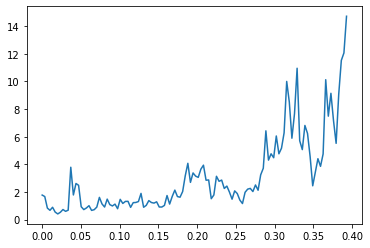

In [ ]:
rnn = RNN(input_size=88, hidden_size=HIDDEN_SIZE , num_classes=88)
rnn = rnn.cuda()
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader)

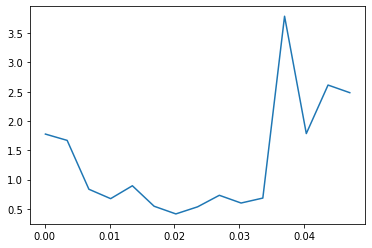

In [ ]:
plt.plot(lrs[:15], losses[:15])

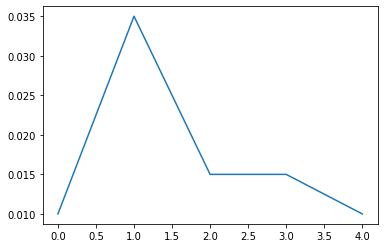

In [ ]:
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [ ]:
def train_model(model, lrs_triangular, epochs_number=EPOCHS_NUMBER, wd=0.0, best_val_loss=float("inf")):
    loss_list = []
    val_list =[]
    
    
    # Determine which Optimzier to use 
    if OPTIMIZER_TYPE == "sgd":
      optimizer = torch.optim.SGD(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)

    else:
      optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    

    # Loop through different Epoch values    
    for epoch_number in range(epochs_number):
        
        model.train()
        epoch_loss = []
        
        # Loop through different Learning rates 
        for lr, batch in zip(lrs_triangular, trainset_loader):
            

            optimizer.param_groups[0]['lr'] = lr


            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            # Get Loss
            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            # Clip Gradient
            torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)

            optimizer.step()

        # Get Training Loss 
        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        # Get Validation Loss
        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)

        # Save the best model (based on validation score)
        if current_val_loss < best_val_loss:
            
            # Save the Model
            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    
    return best_val_loss

In [ ]:
rnn = RNN(input_size=88, hidden_size=HIDDEN_SIZE , num_classes=88)
rnn = rnn.cuda()
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular)

Training Loss: Epoch: 0 : 2.1623849074045816
Validation Loss: Epoch: 0 : 1.6935843489414586e-06

Training Loss: Epoch: 1 : 0.692634383837382
Validation Loss: Epoch: 1 : 2.79784685033751e-06

Training Loss: Epoch: 2 : 1.3085478643576305
Validation Loss: Epoch: 2 : 2.3193705495276846e-06

Training Loss: Epoch: 3 : 0.7028815845648447
Validation Loss: Epoch: 3 : 3.1708594539043955e-06

Training Loss: Epoch: 4 : 0.5774536728858948
Validation Loss: Epoch: 4 : 2.3555643876359257e-06

Training Loss: Epoch: 5 : 0.509856104850769
Validation Loss: Epoch: 5 : 1.8961513165816414e-06

Training Loss: Epoch: 6 : 0.45547057191530865
Validation Loss: Epoch: 6 : 1.9067117187451002e-06

Training Loss: Epoch: 7 : 0.39215265214443207
Validation Loss: Epoch: 7 : 1.910924177647081e-06

Training Loss: Epoch: 8 : 0.37676292657852173
Validation Loss: Epoch: 8 : 1.6602968806260818e-06

Training Loss: Epoch: 9 : 0.44468720257282257
Validation Loss: Epoch: 9 : 1.8620381718601857e-06

Training Loss: Epoch: 10 : 0.32

In [ ]:
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=EPOCHS_NUMBER, wd=1e-4, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.2510971824328105
Validation Loss: Epoch: 0 : 9.583611448892784e-07

Training Loss: Epoch: 1 : 0.20511416345834732
Validation Loss: Epoch: 1 : 9.84763203970478e-07

Training Loss: Epoch: 2 : 0.2133757323026657
Validation Loss: Epoch: 2 : 9.326515656074194e-07

Training Loss: Epoch: 3 : 0.1952621415257454
Validation Loss: Epoch: 3 : 8.20921832648746e-07

Training Loss: Epoch: 4 : 0.195875716706117
Validation Loss: Epoch: 4 : 7.705121388755323e-07

Training Loss: Epoch: 5 : 0.19830949356158575
Validation Loss: Epoch: 5 : 7.922164298733827e-07

Training Loss: Epoch: 6 : 0.19068344682455063
Validation Loss: Epoch: 6 : 7.418832978072297e-07

Training Loss: Epoch: 7 : 0.19405128558476767
Validation Loss: Epoch: 7 : 6.753705588474217e-07

Training Loss: Epoch: 8 : 0.17352295915285745
Validation Loss: Epoch: 8 : 6.794847782791002e-07

Training Loss: Epoch: 9 : 0.18525265653928122
Validation Loss: Epoch: 9 : 7.411943819003449e-07

Training Loss: Epoch: 10 : 0.18211874

In [ ]:
lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=EPOCHS_NUMBER, wd=1e-4*5, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.22093740850687027
Validation Loss: Epoch: 0 : 8.013079350232348e-07

Training Loss: Epoch: 1 : 0.19223379095395407
Validation Loss: Epoch: 1 : 7.142752330141824e-07

Training Loss: Epoch: 2 : 0.17157069345315298
Validation Loss: Epoch: 2 : 7.579319394007276e-07

Training Loss: Epoch: 3 : 0.2605939010779063
Validation Loss: Epoch: 3 : 8.152973285654199e-07

Training Loss: Epoch: 4 : 0.20618784427642822
Validation Loss: Epoch: 4 : 7.668073487062834e-07

Training Loss: Epoch: 5 : 0.1987799679239591
Validation Loss: Epoch: 5 : 7.085536051138444e-07

Training Loss: Epoch: 6 : 0.19319542249043783
Validation Loss: Epoch: 6 : 8.071906508625736e-07

Training Loss: Epoch: 7 : 0.18083423127730688
Validation Loss: Epoch: 7 : 7.274981107650545e-07

Training Loss: Epoch: 8 : 0.17143611361583075
Validation Loss: Epoch: 8 : 7.065113862703965e-07

Training Loss: Epoch: 9 : 0.18043066064516702
Validation Loss: Epoch: 9 : 7.008199584848249e-07

Training Loss: Epoch: 10 : 0.175

In [ ]:
# Use the RNN that produced the best validaiton loss
rnn.load_state_dict('music_model_padfront_regularized.pth')

# Music Generation

In [ ]:
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):

    # Arbitrary Starting Point
    if starting_sequence is None:

        # Initialize the current sequence         
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    
    # If we have a given starting point
    else:
        current_sequence_input = starting_sequence
        
    # Create the output sequence 
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    # Sample For the desired length 
    for i in range(sample_length):

        # Use the current sequence to generate a new sequence 
        output, hidden = rnn(current_sequence_input, [1], hidden)

        # Get the probabilites of possible notes from the output and temperature
        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        # Sample from the multinomial distribution and set this new sequence to be current sequence 
        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        # Returns tensor 
        current_sequence_input = Variable(current_sequence_input.float())

        # Append this current sequence to our entire output
        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    
    # Finalize the Output and return
    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [ ]:
testset = NotesGenerationDataset('./Kanye/test/', longest_sequence_length=None)

testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var.shape

torch.Size([160, 1, 88])

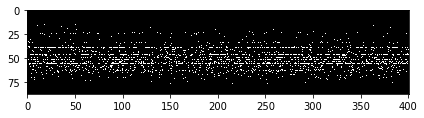

In [ ]:
sample = sample_from_piano_rnn(rnn, sample_length=SAMPLE_LENGTH, temperature=TEMPERATURE,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite(RNN_TYPE+" Clip:"+str(CLIP)+" Epochs:"+str(EPOCHS_NUMBER)+" Optimizer:"+OPTIMIZER_TYPE+" Hidden:"+str(HIDDEN_SIZE)+" Dropout:"+str(DROPOUT)+" Dropout Rate:"+str(DROPOUT_RATE)+" Length:"+str(SAMPLE_LENGTH)+" Temperature:"+str(TEMPERATURE)+" DT:"+str(DT)+".mid", sample.transpose(), dt=DT)

In [ ]:
FileLink(RNN_TYPE+" Clip:"+str(CLIP)+" Epochs:"+str(EPOCHS_NUMBER)+" Optimizer:"+OPTIMIZER_TYPE+" Hidden:"+str(HIDDEN_SIZE)+" Dropout:"+str(DROPOUT)+" Dropout Rate:"+str(DROPOUT_RATE)+" Length:"+str(SAMPLE_LENGTH)+" Temperature:"+str(TEMPERATURE)+" DT:"+str(DT)+".mid")

/content/gru Clip:3 Epochs:25 Optimizer:adam Hidden:512 Dropout:normal Dropout Rate:0.5 Length:400 Temperature:0.8 DT:0.25.mid

## Note : Please convert the midi file to .mp3 or .wav format to listen
## I would try to update the notebook providing that feature in the future

In [ ]:
# Error
#import IPython.display as ipd
#ipd.Audio('./sample_reg_019.mp3')